<a href="https://colab.research.google.com/github/arieshatechnologies/kr_works_old/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GRU, Dropout, Add, LayerNormalization,
    GlobalAveragePooling1D, MultiHeadAttention, Multiply,
    Conv1D, Reshape, Softmax
)
from scipy.stats import qmc
from sklearn.impute import KNNImputer
from tensorflow.keras.optimizers import Adam, SGD, Nadam


In [61]:
# Step 1: Load and preprocess data
df = pd.read_excel("/content/solar complete data.xlsx")
df['DATE &TIME'] = pd.to_datetime(df['DATE &TIME'], errors='coerce')
df.set_index('DATE &TIME', inplace=True)
df.fillna(df.mean(), inplace=True)
#df.interpolate(method='time', inplace=True)  # Time-based interpolation
print(df.isnull().sum())
# Feature and target selection
X_gen = df.drop(['INVERTER 1 TODAY GENERATION (KWH)', 'INVERTER 2 TODAY GENERATION (KWH)'], axis=1)
Y = df[['INVERTER 1 TODAY GENERATION (KWH)']]
imputer = KNNImputer(n_neighbors=5)
X= imputer.fit_transform(X_gen)
X = pd.DataFrame(X, columns=X_gen.columns)

INVERTER 1 TODAY GENERATION (KWH)    0
INVERTER 2 TODAY GENERATION (KWH)    0
OUTGOING TODAY EXPORT (KWH)          0
OUTGOING TODAY IMPORT (KWH)          0
PLANT PEAK POWER (KW)                0
INVERTER PEAK POWER (KW)             0
INVERTER 1 PEAK AC POWER (KW)        0
INVERTER 2 PEAK AC POWER (KW)        0
CUMM TILT IRRADIATION (KWh/m2)       0
PEAK TILT IRRADIATION (Wh/m2)        0
TILT RADIATION (Wh/m2)               0
CO2\n                                0
PLANT CUF\n(%)                       0
PLANT PR\n(%)                        0
MODULE TEMP (*C)                     0
AMBIENT TEMP (*C)                    0
WIND SPEED (Km/Hr)                   0
dtype: int64


In [62]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

In [63]:
# Data Preprocessing
def create_sequences(X_data, Y_data, seq_length):
    X_seq, Y_seq = [], []
    for i in range(len(X_data) - seq_length):
        X_seq.append(X_data[i:i + seq_length])
        Y_seq.append(Y_data[i + seq_length])
    return np.array(X_seq), np.array(Y_seq)
SEQ_LENGTH = 12  # 24 time steps
X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, SEQ_LENGTH)

In [64]:
# Splitting data into train (70%), validation (10%), and test (20%)
# Step 3: Split data
train_size = int(0.7 * len(X_seq))
val_size = int(0.2 * len(X_seq))
test_size = len(X_seq) - train_size - val_size

X_train, Y_train = X_seq[:train_size], Y_seq[:train_size]
X_val, Y_val = X_seq[train_size:train_size + val_size], Y_seq[train_size:train_size + val_size]
X_test, Y_test = X_seq[train_size + val_size:], Y_seq[train_size + val_size:]

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Testing size: {len(X_test)}")


Training size: 12168, Validation size: 3476, Testing size: 1739


In [65]:
from keras.layers import Layer

class FeatureAttention(tf.keras.layers.Layer):
    def __init__(self, n_features, **kwargs):
        super(FeatureAttention, self).__init__(**kwargs)
        self.n_features = n_features
        self.dense_ve = Dense(self.n_features, activation="relu")
        self.dense_we = Dense(self.n_features, activation="relu")
        self.dense_ws = Dense(self.n_features, activation="linear")

    def call(self, inputs):
        # Compute feature-level attention scores
        e_t = self.dense_ve(inputs) * self.dense_we(inputs)
        e_t = tf.reduce_sum(e_t, axis=-1, keepdims=True)
        attention_scores = tf.keras.activations.sigmoid(e_t)

        # Apply attention scores to features
        s_t = Multiply()([attention_scores, self.dense_ws(inputs)])
        return s_t
# Update the feature_attention function to use the custom layer
def feature_attention(input_tensor):
    n_features = input_tensor.shape[-1]
    return FeatureAttention(n_features)(input_tensor)

In [66]:
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3, num_heads=4, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)
        self.conv = Conv1D(filters=64, kernel_size=kernel_size, padding="same", activation="relu")
        self.dense_vc = Dense(64, activation="tanh")
        self.dense_wc = Dense(64, activation="tanh")
        self.num_heads = num_heads

    def call(self, inputs):
        # Convolution to capture temporal dependencies
        conv_output = self.conv(inputs)

        # Compute temporal attention scores
        attention_scores = self.dense_vc(conv_output) * self.dense_wc(conv_output)
        attention_scores = tf.reduce_sum(attention_scores, axis=-1, keepdims=True)
        attention_weights = tf.keras.activations.sigmoid(attention_scores)

        # Apply attention weights to temporal features
        attended_features = Multiply()([attention_weights, conv_output])
        return attended_features

# Update the temporal_attention function to use the custom layer
def temporal_attention(input_tensor, kernel_size=3, num_heads=4):
    return TemporalAttention(kernel_size, num_heads)(input_tensor)

In [67]:
# DA-SGRU Model
def build_dasgru_model(input_shape, activation='relu'):
    inputs = Input(shape=input_shape)

    # Reshape the input to 3D (None, 1, features) for GRU layer
    reshaped_input = Reshape((1, -1))(inputs)

    # Apply feature attention
    feature_attention_output = feature_attention(reshaped_input)

    # Apply GRU layers
    x = GRU(64, return_sequences=True)(feature_attention_output)
    x = GRU(64, return_sequences=True)(x)

    # Apply temporal attention
    temporal_attention_output = temporal_attention(x)

    # Multi-head attention and normalization
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(
        temporal_attention_output, temporal_attention_output
    )
    attention_output = LayerNormalization()(Add()([attention_output, temporal_attention_output]))

    # Final output layer
    outputs = Dense(1, activation='linear')(attention_output)

    return Model(inputs=inputs, outputs=outputs)

In [68]:
def build_dasgru_model(input_shape, activation='relu'):
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape the input to 3D for GRU layers and attention
    reshaped_input = Reshape((1, -1))(inputs)

    # Apply Feature Attention
    feature_attention_output = FeatureAttention(input_shape[-1])(reshaped_input)

    # Pass through two GRU layers
    x = tf.keras.layers.GRU(64, return_sequences=True)(feature_attention_output)
    x = tf.keras.layers.GRU(64, return_sequences=True)(x)

    # Apply Temporal Attention
    temporal_attention_output = TemporalAttention(kernel_size=3)(x)

    # Apply Multi-Head Attention
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(
        temporal_attention_output, temporal_attention_output
    )

    # Residual connection and Layer Normalization
    attention_output = tf.keras.layers.LayerNormalization()(
        tf.keras.layers.Add()([attention_output, temporal_attention_output])
    )

    # Final output layer
    outputs = tf.keras.layers.Dense(1, activation="linear")(attention_output)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [69]:
# Optimization Functions
def initialize_population(bounds, population_size):
    dim = len(bounds)
    sobol = qmc.Sobol(d=dim)
    samples = sobol.random_base2(m=int(np.log2(population_size)))
    population = np.zeros_like(samples)
    for i, (low, high) in enumerate(bounds):
        population[:, i] = low + (high - low) * samples[:, i]
    return population

In [11]:
def evaluate_population(population, model_fn, train_data, val_data):
    fitness = []
    learning_rates = [0.0001, 0.001, 0.01,0.1]
    batch_sizes = [16, 32, 64,128,256]
    epochs = [30, 50, 80, 100]
    lookbacks = [1, 2, 3]
    for individual in population:
        lr_idx, bs_idx, epoch_idx, opt_idx, act_idx,lookback_idx = individual

        # Validate indices
        try:
            lr_idx = int(lr_idx) if not np.isnan(lr_idx) and lr_idx < len(learning_rates) else 0
            bs_idx = int(bs_idx) if not np.isnan(bs_idx) and bs_idx < len(batch_sizes) else 0
            epoch_idx = int(epoch_idx) if not np.isnan(epoch_idx) and epoch_idx < len(epochs) else 0
            lookback_idx = int(lookback_idx) if not np.isnan(lookback_idx) and lookback_idx < len(batch_sizes) else 0
            opt_idx = int(opt_idx) if not np.isnan(opt_idx) else 0
            act_idx = int(act_idx) if not np.isnan(act_idx) else 0
        except ValueError:
            # If invalid indices, assign default values
            lr_idx, bs_idx, epoch_idx,lookback_idx, opt_idx, act_idx = 0, 0, 0, 0, 0

        learning_rate = learning_rates[lr_idx]
        batch_size = batch_sizes[bs_idx]
        num_epochs = epochs[epoch_idx]
        lookback = lookbacks[lookback_idx]
        val_loss = train_and_evaluate_model(
            model_fn, train_data, val_data,
            learning_rate, batch_size, num_epochs,
            optimizer_idx=opt_idx, activation_idx=act_idx
        )
        fitness.append(val_loss)

    return np.array(fitness)

In [70]:
def train_and_evaluate_model(model_fn, train_data, val_data, learning_rate, batch_size, epochs, optimizer_idx, activation_idx):
    optimizers = [Adam, SGD, Nadam]
    activations = ["relu", "tanh", "sigmoid"]

    model = model_fn(train_data[0].shape[1:], activation=activations[int(activation_idx)])
    model.compile(optimizer=optimizers[int(optimizer_idx)](learning_rate=learning_rate), loss="mse")

    model.fit(train_data[0], train_data[1], batch_size=batch_size, epochs=epochs, verbose=0)
    val_loss = model.evaluate(val_data[0], val_data[1], verbose=0)
    return val_loss

In [71]:
def update_exploration(X, c2, X_min, X_max, rand_indices, fitness_rand, fitness_i):
    r = np.random.uniform(0, 1, X.shape)
    ability = np.exp(-fitness_rand / fitness_i)
    new_X = X[rand_indices] + c2 * ability[:, None] * ((X_max - X_min) * r + X_min)
    return np.clip(new_X, X_min, X_max)

In [72]:

def update_exploitation(X, c3, X_food, Temp, r, Q, fitness_best, fitness_i, mode,X_min, X_max):
    if mode == "fight":
        FM = np.exp(-fitness_best / fitness_i)
        new_X = X + c3 * FM[:, None] * r * (X_food * Q - X)
    else:
        M = np.exp(-fitness_i / fitness_best)
        new_X = X + c3 * M[:, None] * r * (X_food * Q - X)
    return np.clip(new_X, X_min, X_max)

In [73]:
def optimize_hyperparameters(bounds, population_size, max_iterations, model_fn, train_data, val_data):
    X_train, Y_train = train_data
    X_val, Y_val = val_data
    X_min, X_max = np.array(bounds)[:, 0], np.array(bounds)[:, 1]
    population = initialize_population(bounds, population_size)
    males, females = np.split(population, 2)

    for t in range(1, max_iterations + 1):
        fitness_m = evaluate_population(males, model_fn, train_data, val_data)
        fitness_f = evaluate_population(females, model_fn, train_data, val_data)

        best_male = males[np.argmin(fitness_m)]
        best_female = females[np.argmin(fitness_f)]
        f_food = best_male if fitness_m.min() < fitness_f.min() else best_female

        Temp = np.exp(-t / max_iterations)
        Q = 0.5 * (0.3 + 0.7 * np.tanh(0.75 * np.pi * t / max_iterations))

        if Q < 0.25:
            males = update_exploration(males, c2=0.5, X_min=X_min, X_max=X_max,
                                       rand_indices=np.random.randint(0, len(females), len(males)),
                                       fitness_rand=fitness_f[np.random.randint(0, len(females))],
                                       fitness_i=fitness_m)
        else:
            males = update_exploitation(males, c3=0.5, X_food=f_food, Temp=Temp,
                                        r=np.random.rand(len(males), 1),
                                        Q=Q, fitness_best=fitness_m.min(), fitness_i=fitness_m,
                                        mode="fight", X_min=X_min, X_max=X_max)
            females = update_exploitation(females, c3=0.5, X_food=f_food, Temp=Temp,
                                      r=np.random.rand(len(females), 1),
                                      Q=Q, fitness_best=fitness_f.min(), fitness_i=fitness_f,
                                      mode="flight", X_min=X_min, X_max=X_max)

    best_solution = np.concatenate((males, females), axis=0)[np.argmin(np.concatenate((fitness_m, fitness_f)))]
    return best_solution

In [74]:
def build_dasgru_model(input_shape, activation='relu'):
    inputs = Input(shape=input_shape)

    # Reshape the input to ensure it's in the correct 3D shape for Conv1D
    if len(input_shape) == 2:
        x = Reshape((input_shape[0], 1))(inputs)  # Reshape to (batch_size, timesteps, features)
    else:
        x = inputs  # If already 3D, no reshaping needed

    # Convolutional layer
    x = Conv1D(64, 3, padding="same", activation=activation)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = Attention()([x, x])  # Self-attention layer
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation=activation)(x)
    x = Dropout(0.2)(x)  # Regularization
    outputs = Dense(1)(x)  # Output layer

    model = Model(inputs, outputs)
    return model


In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, GRU, Dropout, Multiply, Softmax, Add, LayerNormalization, Conv1D,
    GlobalAveragePooling1D, Reshape, Bidirectional, Attention  # Import Attention layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import qmc

# Hyperparameters and their possible values
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64, 128, 256]
epochs = [30, 50, 80, 100]
lookbacks = [1, 2, 3]
optimizers = [Adam, SGD, Nadam]
activations = ["relu", "tanh", "sigmoid"]

# Example Bounds and Hyperparameter Optimization
bounds = [
    [0, 3],  # Learning rate index
    [0, 2],  # Optimizer index
    [0, 4],  # Batch size index
    [0, 2],  # Activation index
    [0, 3],  # Epochs index
    [0, 2]   # Lookback index
]

# Example function for building model (ensure this is defined)
def build_dasgru_model(input_shape, activation='relu'):
    inputs = Input(shape=input_shape)

    # Reshape input to 3D tensor
    x = Reshape((input_shape[0], 1))(inputs)

    # Convolutional layer
    x = Conv1D(64, 3, padding="same", activation=activation)(x)

    # Bidirectional GRU layer
    x = Bidirectional(GRU(64, return_sequences=True))(x)

    # Add attention layer
    x = Attention()([x, x])

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Dense layers
    x = Dense(64, activation=activation)(x)
    x = Dropout(0.2)(x)  # Regularization
    outputs = Dense(1)(x)  # Output layer

    model = Model(inputs, outputs)
    return model

# Hyperparameter optimization function
def optimize_hyperparameters(bounds, population_size, max_iterations, model_fn, train_data, val_data):
    X_train, Y_train = train_data
    X_val, Y_val = val_data

    # Latin Hypercube Sampling to sample values from the bounds
    sampler = qmc.LatinHypercube(d=len(bounds))
    samples = sampler.random(n=population_size)
    scaled_samples = qmc.scale(samples, [b[0] for b in bounds], [b[1] for b in bounds])

    best_mse = float('inf')
    best_params = None

    # Run the optimization for a set number of iterations
    for i in range(max_iterations):
        for sample in scaled_samples:
            # Extract hyperparameters from the sample
            lr = learning_rates[int(sample[0])]
            optimizer = optimizers[int(sample[1])](learning_rate=lr)
            batch_size = batch_sizes[int(sample[2])]
            activation = activations[int(sample[3])]
            num_epochs = epochs[int(sample[4])]

            # Build and compile the model
            model = model_fn(X_train.shape[1:], activation=activation)
            model.compile(optimizer=optimizer, loss='mse')

            # Train the model
            model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=0)

            # Evaluate the model
            preds = model.predict(X_val)
            mse = mean_squared_error(Y_val, preds)

            # Store the best model parameters based on MSE
            if mse < best_mse:
                best_mse = mse
                best_params = (lr, optimizer, batch_size, activation, num_epochs)

    return best_params

# Example usage (replace with actual data)
X_train = np.random.randn(100, 10)  # Example input shape (100 samples, 10 features)
Y_train = np.random.randn(100, 1)  # Example target
X_val = np.random.randn(20, 10)    # Validation data
Y_val = np.random.randn(20, 1)

# Run hyperparameter optimization
optimal_hyperparameters = optimize_hyperparameters(
    bounds, population_size=5, max_iterations=3,
    model_fn=build_dasgru_model, train_data=(X_train, Y_train), val_data=(X_val, Y_val)
)

print("Optimal Hyperparameters:", optimal_hyperparameters)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Optimal Hyperparameters: (0.0001, <keras.src.optimizers.sgd.SGD object at 0x7e617d264b10>, 32, 'relu', 30)


In [76]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64, 128, 256]
epochs = [30, 50, 80, 100]
lookbacks = [1, 2, 3]
optimizers = [Adam, SGD, Nadam]
activations = ["relu", "tanh", "sigmoid"]

# Example Bounds (replace these with actual bounds from your optimization function)
bounds = [
    [0, 3],  # Learning rate index
    [0, 2],  # Optimizer index
    [0, 4],  # Batch size index
    [0, 2],  # Activation index
    [0, 3],  # Epochs index
    [0, 2]   # Lookback index
]

# Function to map continuous values to indices
def map_continuous_to_index(value, min_val, max_val, num_options):
    return int(np.clip(np.round(value * (num_options - 1)), 0, num_options - 1))

# Simulate the result of the optimization process (this should be replaced by actual optimization)
optimal_hyperparameters = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]  # Replace with actual optimization results

# Now, get the indices for each hyperparameter
learning_rate_index = map_continuous_to_index(optimal_hyperparameters[0], bounds[0][0], bounds[0][1], len(learning_rates))
optimizer_index = map_continuous_to_index(optimal_hyperparameters[1], bounds[1][0], bounds[1][1], len(optimizers))
batch_size_index = map_continuous_to_index(optimal_hyperparameters[2], bounds[2][0], bounds[2][1], len(batch_sizes))
activation_index = map_continuous_to_index(optimal_hyperparameters[3], bounds[3][0], bounds[3][1], len(activations))
epochs_index = map_continuous_to_index(optimal_hyperparameters[4], bounds[4][0], bounds[4][1], len(epochs))
lookback_index = map_continuous_to_index(optimal_hyperparameters[5], bounds[5][0], bounds[5][1], len(lookbacks))

# Now you can get the corresponding hyperparameter values
learning_rate = learning_rates[learning_rate_index]
optimizer = optimizers[optimizer_index]
batch_size = batch_sizes[batch_size_index]
activation = activations[activation_index]
epochs = epochs[epochs_index]
lookback = lookbacks[lookback_index]

# Print the optimal hyperparameters with their corresponding indices
print(f"Optimal Hyperparameters (Indexes):")
print(f"Learning Rate Index: {learning_rate_index}, Value: {learning_rate}")
print(f"Optimizer Index: {optimizer_index}, Value: {optimizer.__name__}")
print(f"Batch Size Index: {batch_size_index}, Value: {batch_size}")
print(f"Activation Index: {activation_index}, Value: {activation}")
print(f"Epochs Index: {epochs_index}, Value: {epochs}")
print(f"Lookback Index: {lookback_index}, Value: {lookback}")

Optimal Hyperparameters (Indexes):
Learning Rate Index: 2, Value: 0.01
Optimizer Index: 1, Value: SGD
Batch Size Index: 2, Value: 64
Activation Index: 1, Value: tanh
Epochs Index: 2, Value: 80
Lookback Index: 1, Value: 2


In [77]:
print(model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 1, 15)          │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_attention_8       │ (None, 1, 15)          │            720 │ reshape_8[0][0]        │
│ (FeatureAttention)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_16 (GRU)              │ (None, 1, 64)          │         15,552 │ feature_attention_8[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_17 (GRU)              │ (None, 1, 64)          │         24,960 │ gru_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ temporal_attention_8      │ (None, 1, 64)          │         20,672 │ gru_17[0][0]           │
│ (TemporalAttention)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 1, 64)          │         66,368 │ temporal_attention_8[… │
│ (MultiHeadAttention)      │                        │                │ temporal_attention_8[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 1, 64)          │              0 │ multi_head_attention_… │
│                           │                        │                │ temporal_attention_8[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 1, 64)          │            128 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 1, 1)           │             65 │ layer_normalization_7… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 385,397 (1.47 MB)

 Trainable params: 128,465 (501.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,932 (1003.64 KB)

None


In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
def evaluate_and_visualize(model, X_test, Y_test, scaler_Y):
    # Reshape to (samples, timesteps * features)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Generate predictions
    predictions = model.predict(X_test)
    predictions = scaler_Y.inverse_transform(predictions)
    Y_test = scaler_Y.inverse_transform(Y_test[:len(predictions)])

    # Calculate metrics
    mse = mean_squared_error(Y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, predictions)
    mape = np.mean(np.abs((Y_test - predictions) / (Y_test + 1e-6))) * 100  # Handle zero division

    # Print metrics
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")
    return mse, rmse, r2, mape

In [79]:
n_samples, timesteps, features = X_test.shape
X_test = X_test.reshape(-1, features)  # Flatten to (n_samples * timesteps, features)

# Adjust Y_test to match the flattened X_test
Y_test = np.repeat(Y_test, timesteps, axis=0)  # Repeat Y_test for each timestep

# Generate predictions
predictions = model.predict(X_test)  # Shape: (n_samples, 1, 1) or similar
predictions = predictions.reshape(-1, 1)  # Reshape to 2D: (n_samples, 1)

# Inverse transform predictions and Y_test
predictions = scaler_Y.inverse_transform(predictions)
Y_test = scaler_Y.inverse_transform(Y_test[:len(predictions)])  # Ensure consistent size

# Calculate metrics
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, predictions)
mape = np.mean(np.abs((Y_test - predictions) / Y_test)) * 100
print(f"Metrics:\nMSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")

653/653 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Metrics:
MSE: 7390475.7073, RMSE: 2718.5429, R²: -0.3453, MAPE: inf


<ipython-input-79-82ed0a8557d9>:19: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((Y_test - predictions) / Y_test)) * 100


In [81]:
 # Inverse transform predictions and Y_test
predictions = scaler_Y.inverse_transform(predictions)
Y_test = scaler_Y.inverse_transform(Y_test[:len(predictions)])  # Ensure consistent size

print("Some Predictions:", predictions[:10])
print("Some Actuals:", Y_test[:10])

Some Predictions: [[1.12460628e+11]
 [1.12908141e+11]
 [1.12224870e+11]
 [1.10485725e+11]
 [1.03898137e+11]
 [9.76774021e+10]
 [9.63942973e+10]
 [9.44201974e+10]
 [9.25494641e+10]
 [9.16421100e+10]]
Some Actuals: [[5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]
 [5.52666408e+11]]


In [82]:
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print(model.input_shape)

X_test shape: (20868, 15)
Y_test shape: (20868, 1)
(None, 15)


In [83]:
if np.any(Y_test == 0):
    print("Warning: Zero values in Y_test detected!")

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# --- Define Metrics and Visualization ---
def evaluate_and_visualize(model_fn, X_test, Y_test, scaler_Y):
    # Generate predictions
    Y_pred_test = model.predict(X_test)

    # Reshape predictions to 2D if necessary
    if Y_pred_test.ndim == 3:
        Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0], -1)

    # Rescale predictions and true values
    Y_pred_test_rescaled = scaler_Y.inverse_transform(Y_pred_test)
    Y_test_rescaled = scaler_Y.inverse_transform(Y_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test_rescaled, Y_pred_test_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test_rescaled, Y_pred_test_rescaled)
    mape = mean_absolute_percentage_error(Y_test_rescaled, Y_pred_test_rescaled)

    print(f"Metrics:\nMSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")



    return mse, rmse, r2, mape

# --- Using the Trained Model ---
# Evaluate the best model and visualize results
mse, rmse, r2, mape = evaluate_and_visualize(model, X_test, Y_test, scaler_Y)

653/653 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Metrics:
MSE: 13021618265759261243946936827904.0000, RMSE: 3608547944223446.5000, R²: -1.0925, MAPE: 1246660144175827968.0000


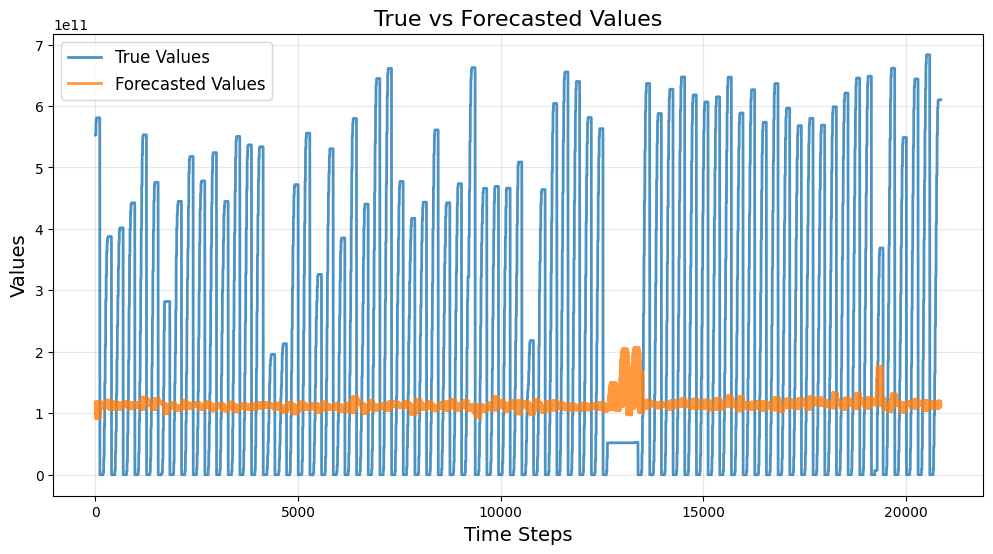

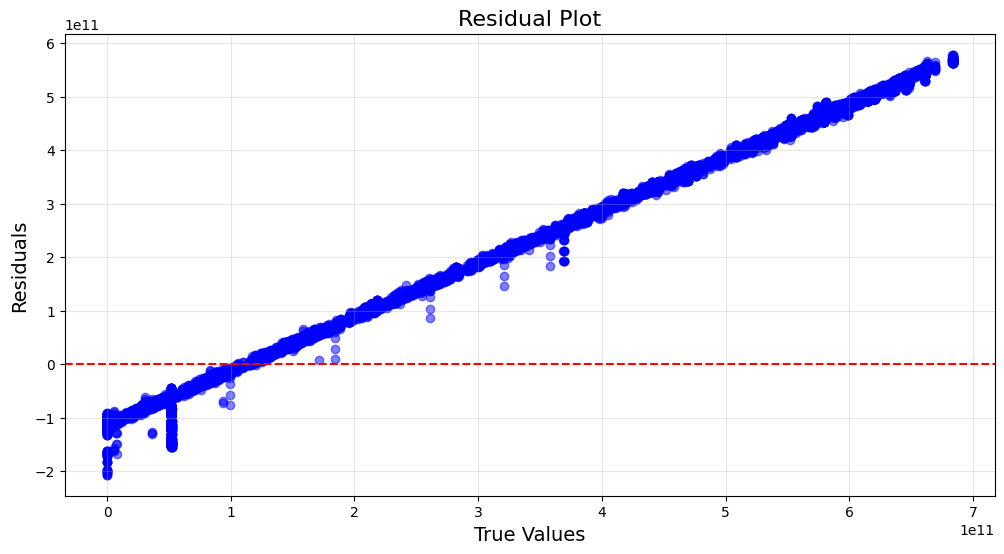

In [85]:
 # --- Visualization ---
    # 1. True vs Forecasted
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='True Values', alpha=0.8, linewidth=2)
plt.plot(predictions, label='Forecasted Values', alpha=0.8, linewidth=2)
plt.title("True vs Forecasted Values", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
 plt.show()

    # 2. Residual Plot
residuals = Y_test-predictions
plt.figure(figsize=(12, 6))
plt.scatter(Y_test, residuals, alpha=0.5, color="blue")
plt.axhline(0, color="red", linestyle="--", linewidth=1.5)
plt.title("Residual Plot", fontsize=16)
plt.xlabel("True Values", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid(alpha=0.3)
plt.show()